<a href="https://colab.research.google.com/github/agnislur/NLP_LSTM-Agn/blob/main/NLP_50d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-7073w2b9
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-7073w2b9
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101056 sha256=f7e6f277740fb7a19842f04ce29b2124cf1d14c36224e9b243fe0b02a2204a67
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0xc3cz7/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [2]:
import re

import numpy as np
import pandas as pd
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Embedding, TimeDistributed, Dropout, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from operator import itemgetter

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Dataset Text (2).csv to Dataset Text (2).csv


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('Dataset Text (2).csv')
df

,Kalimat,Label,Text
0,R1,supports,competition can effectively promote the develo...
1,R2,attacks,competition can effectively promote the develo...
2,R3,supports,what we acquired from team work is not only ho...
3,R4,supports,through cooperation children can learn about i...
4,R5,supports,all of these skills help them to get on well w...
...,...,...,...
1034,R19,attacks,the use of cctv cameras does cause controversy...
1035,R20,supports,this is chiefly to shield oneself from being h...
1036,R21,attacks,privacies are lost with the use of these camer...
1037,R22,attacks,safety should be put first in order to be safe...


In [6]:
df.head()

,Kalimat,Label,Text
0,R1,supports,competition can effectively promote the develo...
1,R2,attacks,competition can effectively promote the develo...
2,R3,supports,what we acquired from team work is not only ho...
3,R4,supports,through cooperation children can learn about i...
4,R5,supports,all of these skills help them to get on well w...


In [7]:
df.describe()

,Kalimat,Label,Text
count,1039,1039,1039
unique,64,2,1039
top,R1,supports,competition can effectively promote the develo...
freq,63,906,1


In [8]:
df.isnull().sum()

Kalimat    0
Label      0
Text       0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Kalimat  1039 non-null   object
 1   Label    1039 non-null   object
 2   Text     1039 non-null   object
dtypes: object(3)
memory usage: 24.5+ KB


In [10]:
balance_counts = df.groupby('Label')['Label'].agg('count').values
balance_counts

array([133, 906])

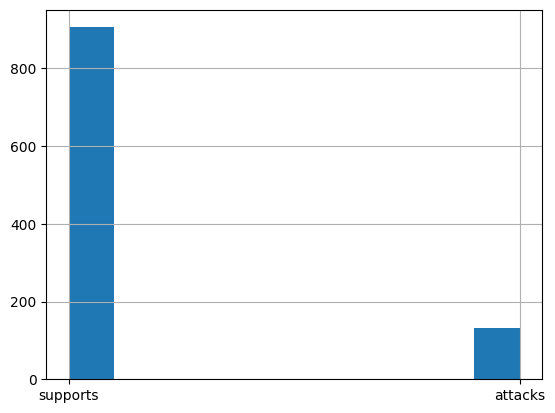

In [11]:
df["Label"].hist()
plt.show()

Tidak balance

In [12]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Kolom '{column}':")
    print(unique_values)
    print()


Kolom 'Kalimat':
['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'R12' 'R13'
 'R14' 'R15' 'R16' 'R17' 'R18' 'R19' 'R20' 'R21' 'R22' 'R23' 'R24' 'R25'
 'R26' 'R27' 'R28' 'R29' 'R30' 'R31' 'R32' 'R33' 'R34' 'R35' 'R36' 'R37'
 'R38' 'R39' 'R40' 'R41' 'R42' 'R43' 'R44' 'R45' 'R46' 'R47' 'R48' 'R49'
 'R50' 'R51' 'R52' 'R53' 'R54' 'R55' 'R56' 'R57' 'R58' 'R59' 'R60' 'R61'
 'R62' 'R63' 'R64']

Kolom 'Label':
['supports' 'attacks']

Kolom 'Text':
['competition can effectively promote the development of economy in order to survive in the competition companies continue to improve their products and service and as a result the whole society prospers'
 'competition can effectively promote the development of economy we should attach more importance to cooperation'
 'what we acquired from team work is not only how to achieve the same goal with others but more importantly how to get along with others through cooperation children can learn about interpersonal skills which are significant in 

In [13]:
# Menghapus kolom 'Kota'
df = df.drop('Kalimat', axis=1)

# Menampilkan DataFrame setelah penghapusan kolom
print("\nDataFrame setelah penghapusan kolom:")
print(df)



DataFrame setelah penghapusan kolom:
         Label                                               Text
0     supports  competition can effectively promote the develo...
1      attacks  competition can effectively promote the develo...
2     supports  what we acquired from team work is not only ho...
3     supports  through cooperation children can learn about i...
4     supports  all of these skills help them to get on well w...
...        ...                                                ...
1034   attacks  the use of cctv cameras does cause controversy...
1035  supports  this is chiefly to shield oneself from being h...
1036   attacks  privacies are lost with the use of these camer...
1037   attacks  safety should be put first in order to be safe...
1038  supports  cctv cameras are essential and therefore must ...

[1039 rows x 2 columns]


In [14]:
df

,Label,Text
0,supports,competition can effectively promote the develo...
1,attacks,competition can effectively promote the develo...
2,supports,what we acquired from team work is not only ho...
3,supports,through cooperation children can learn about i...
4,supports,all of these skills help them to get on well w...
...,...,...
1034,attacks,the use of cctv cameras does cause controversy...
1035,supports,this is chiefly to shield oneself from being h...
1036,attacks,privacies are lost with the use of these camer...
1037,attacks,safety should be put first in order to be safe...


In [15]:
 pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-6gemo_na
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-6gemo_na
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [16]:
import re

import numpy as np
import pandas as pd
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Embedding, TimeDistributed, Dropout, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from operator import itemgetter

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
df.shape

(1039, 2)

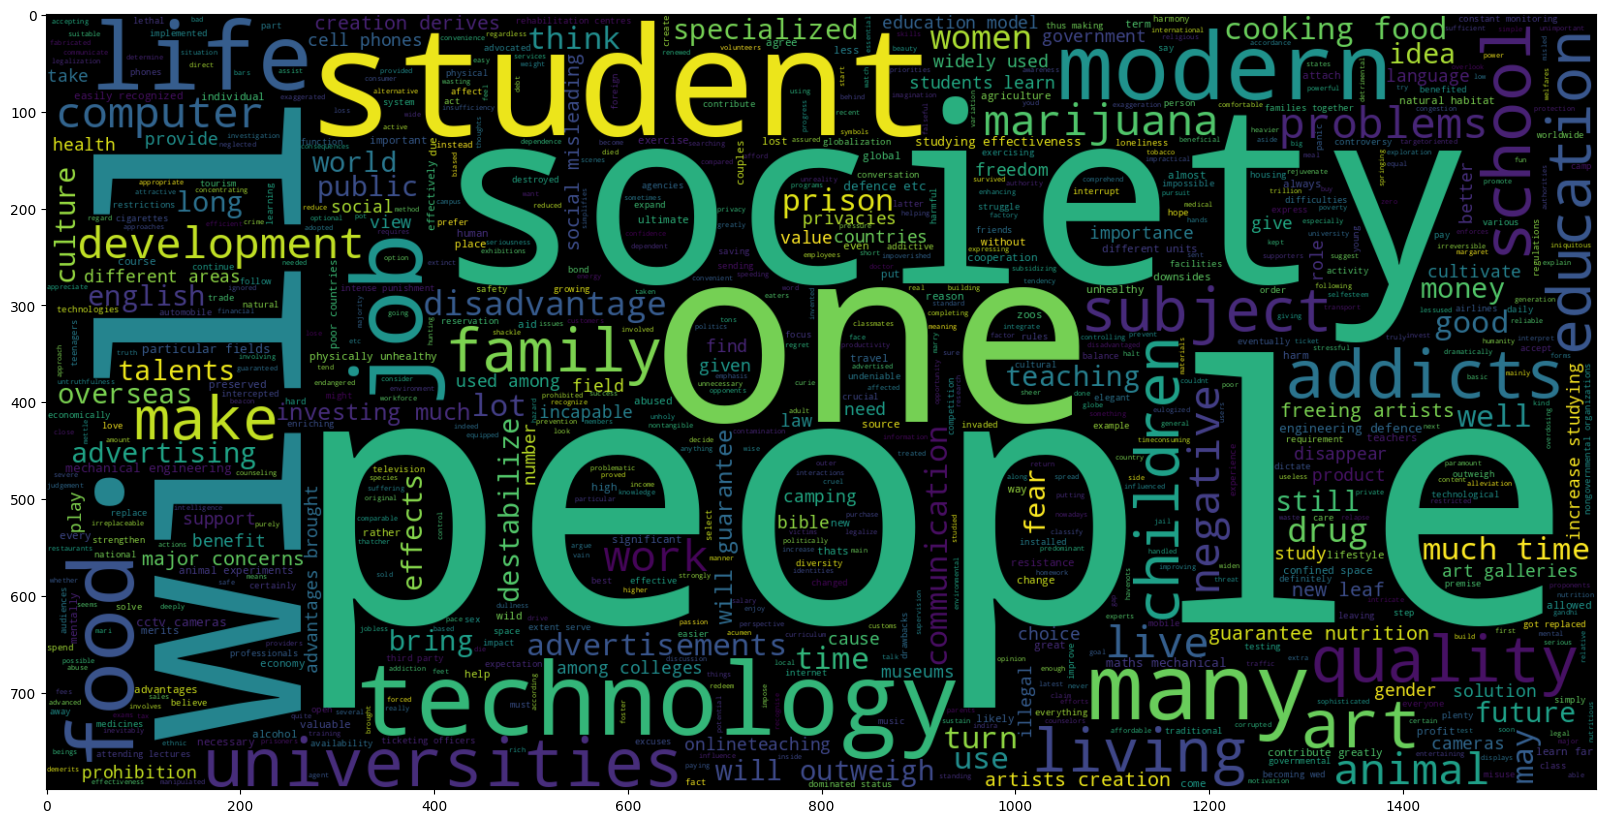

In [19]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Label == 'attacks'].Text))
plt.imshow(wc , interpolation = 'bilinear')

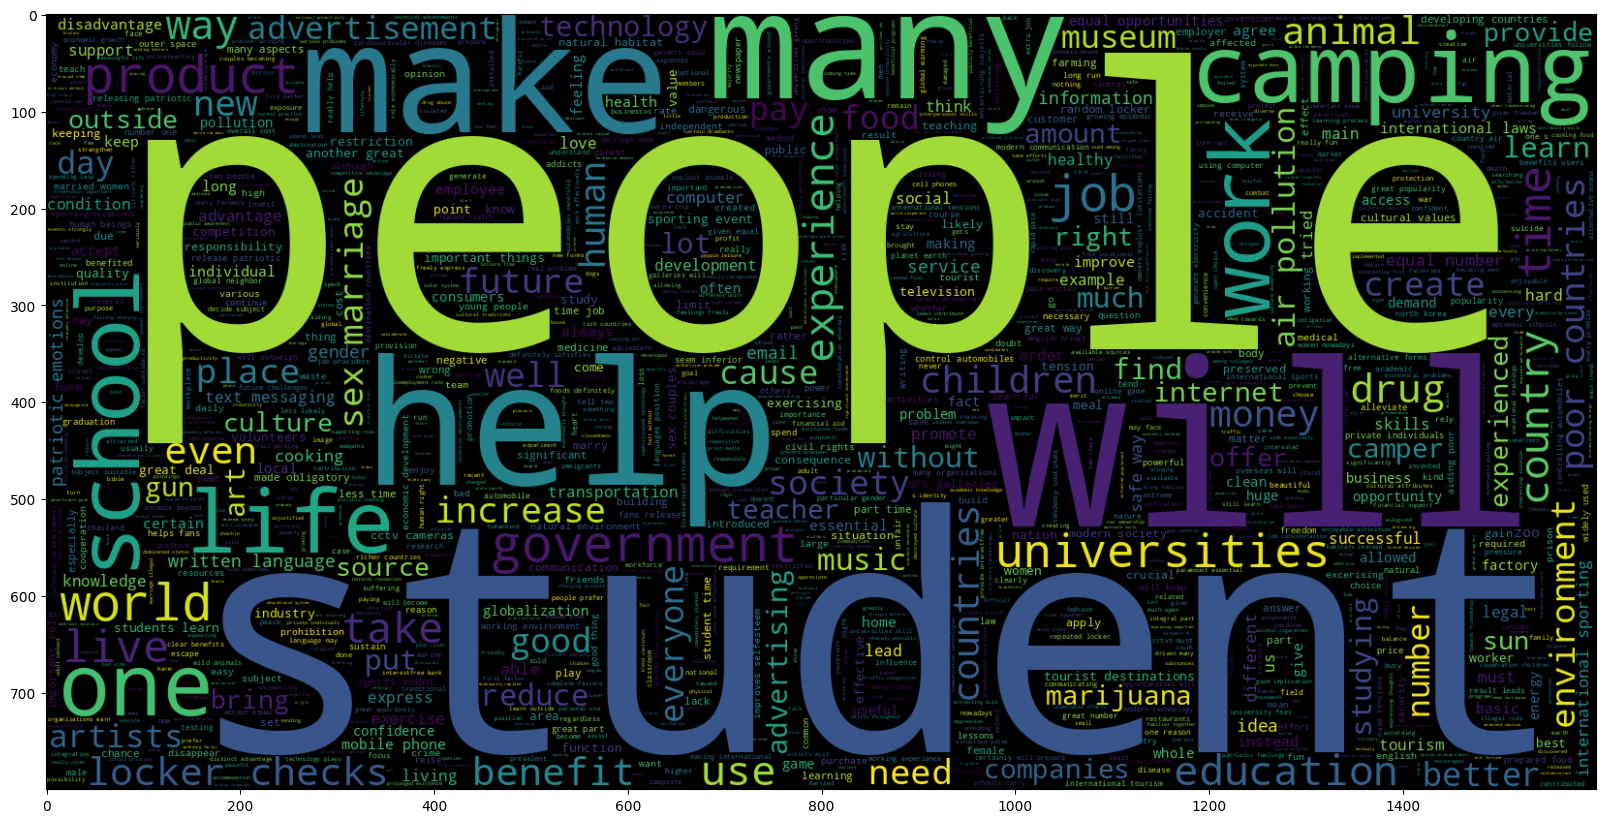

In [20]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Label == 'supports'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

In [23]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 32

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
tokenizer = Tokenizer()
word_index = tokenizer.word_index

In [26]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 831
Test Data size 208


In [27]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Text), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Text), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (831, 32)
Testing X Shape: (208, 32)


In [28]:
labels = train_data.Label.unique().tolist()


In [29]:
encoder = LabelEncoder()
encoder.fit(train_data.Label.to_list())

y_train = encoder.transform(train_data.Label.to_list())
y_test = encoder.transform(test_data.Label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (831, 1)
y_test shape: (208, 1)


In [30]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [31]:
smote = SMOTE(sampling_strategy='auto',random_state=22)
x_res,y_res = smote.fit_resample(x_train,y_train)

In [32]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
GLOVE_EMB = '/content/drive/MyDrive/glove/glove.6B.50d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 10

In [34]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding='utf8')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [35]:
embedding_matrix = np.zeros((500, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_layer = tf.keras.layers.Embedding(500, 300,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [37]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [39]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on CPU...


In [40]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])


Epoch 1/10
52/52 [==============================] - 27s 240ms/step - loss: 0.6840 - accuracy: 0.8580 - val_loss: 0.6746 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - 10s 199ms/step - loss: 0.6658 - accuracy: 0.8724 - val_loss: 0.6570 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - 7s 127ms/step - loss: 0.6487 - accuracy: 0.8724 - val_loss: 0.6406 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - 4s 86ms/step - loss: 0.6325 - accuracy: 0.8724 - val_loss: 0.6251 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 5/10
52/52 [==============================] - 6s 110ms/step - loss: 0.6172 - accuracy: 0.8724 - val_loss: 0.6102 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 6/10
52/52 [==============================] - 6s 117ms/step - loss: 0.6027 - accuracy: 0.8724 - val_loss: 0.5962 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 7/10
52/52 [==============================] - 4s 86ms/step - lo

In [41]:
print('Loss and Accuracy Score :', model.evaluate(x_test, y_test))

7/7 [==============================] - 2s 16ms/step - loss: 0.5477 - accuracy: 0.8702
Loss and Accuracy Score : [0.5476974248886108, 0.870192289352417]


In [42]:
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)
print(classification_report(y_test, y_pred.round()))

13/13 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.87      1.00      0.93       181

    accuracy                           0.87       208
   macro avg       0.44      0.50      0.47       208
weighted avg       0.76      0.87      0.81       208



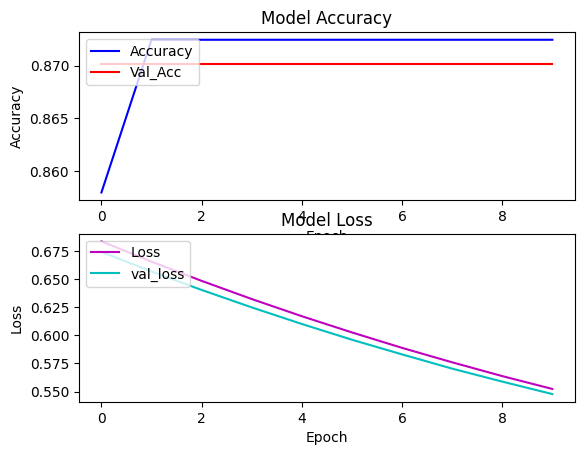

In [43]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Accuracy', 'Val_Acc'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Loss', 'val_loss'], loc = 'upper left')